In [70]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from yellowbrick.cluster import KElbowVisualizer
from joblib import dump, load

In [74]:
project_dir = Path.cwd().parent
data_dir = project_dir / 'data'
raw_data_dir = data_dir / 'raw'
interim_data_dir = data_dir / 'interim'
models_dir = project_dir / 'models'

# Load data

In [7]:
file_url = 'https://raw.githubusercontent.com/AGilarde12/Mall-Customer-Segmentation/master/Data/Mall_Customers.csv'
df = pd.read_csv(file_url)
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [10]:
df.to_csv(raw_data_dir / 'raw.csv', index=False)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
CustomerID                200 non-null int64
Gender                    200 non-null object
Age                       200 non-null int64
Annual Income (k$)        200 non-null int64
Spending Score (1-100)    200 non-null int64
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


# Clean data

In [9]:
df_cleaned = df.copy(deep=True)

In [13]:
df_cleaned.drop(columns='CustomerID', inplace=True)

In [14]:
df_cleaned.to_csv(interim_data_dir / 'cleaned.csv', index=False)

In [40]:
X_train, X_test = train_test_split(df_cleaned, random_state=42, test_size=0.2)

# Data transformations

## Numeric features

In [41]:
X_train_cleaned = X_train.copy(deep=True)

In [46]:
num_cols = X_train_cleaned.select_dtypes(include=['int64']).columns

In [47]:
num_cols

Index(['Age', 'Annual Income (k$)', 'Spending Score (1-100)'], dtype='object')

In [48]:
sc = StandardScaler()
X_train_cleaned.loc[:, num_cols] = sc.fit_transform(X_train_cleaned[num_cols])

## Categorical features

In [52]:
cat_cols = X_train_cleaned.select_dtypes(include=['category', 'object']).columns
cat_cols

Index(['Gender'], dtype='object')

In [53]:
ohe = OneHotEncoder(sparse=False, drop='first')
X_train_cleaned.loc[:, cat_cols] = ohe.fit_transform(X_train_cleaned[cat_cols])

# Gaussian Mixture Model

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f9e92e30e90>,
                 k=None, locate_elbow=True, metric='distortion', model=None,
                 timings=True)

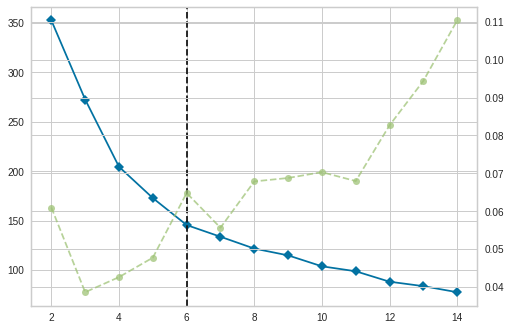

In [58]:
model = KElbowVisualizer(model=KMeans(), k=(2, 15))
model.fit(X_train_cleaned)

In [59]:
n_clusters = model.elbow_value_
n_clusters

6

In [62]:
gmm = GaussianMixture(n_components=n_clusters, random_state=42)
gmm.fit(X_train_cleaned)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=6, n_init=1, precisions_init=None,
                random_state=42, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

In [63]:
preds = gmm.predict(X_train_cleaned)

In [64]:
preds

array([4, 1, 5, 5, 4, 1, 3, 3, 1, 4, 0, 1, 3, 4, 4, 4, 2, 4, 2, 4, 1, 0,
       3, 5, 3, 4, 5, 1, 4, 2, 0, 1, 0, 3, 4, 0, 5, 1, 0, 0, 5, 4, 4, 1,
       1, 4, 1, 5, 2, 0, 5, 1, 4, 3, 3, 2, 1, 5, 3, 0, 5, 5, 4, 1, 4, 0,
       5, 4, 4, 4, 2, 3, 2, 1, 4, 1, 4, 5, 1, 5, 5, 4, 1, 2, 3, 3, 2, 1,
       4, 0, 2, 5, 4, 2, 0, 0, 3, 0, 4, 1, 2, 2, 1, 5, 4, 5, 3, 4, 0, 4,
       2, 1, 4, 5, 3, 4, 1, 1, 3, 4, 1, 0, 1, 1, 4, 5, 4, 4, 2, 0, 5, 4,
       3, 4, 4, 2, 1, 0, 1, 1, 3, 0, 1, 2, 1, 0, 0, 4, 0, 4, 4, 1, 5, 2,
       4, 4, 5, 4, 1, 4])

# Pipelines

In [75]:
num_transformer = Pipeline([
    ('scaler', StandardScaler()),
])

cat_transformer = Pipeline([
    ('ohe', OneHotEncoder()),
])

preprocessor = ColumnTransformer([
    ('scaler', num_transformer, num_cols),
    ('ohe', cat_transformer, cat_cols)
])

gmm_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('estimator', GaussianMixture(n_components=n_clusters, random_state=42))
])

In [76]:
gmm_pipe.fit(X_train)
preds = gm_pipe.predict(X_train)

In [72]:
obs = X_train.loc[0, :].to_frame()
obs

,0
Gender,Male
Age,19
Annual Income (k$),15
Spending Score (1-100),39


# Save model

In [78]:
dump(gmm_pipe, models_dir / 'gmm_pipe.joblib')

['/home/jovyan/work/models/gmm_pipe.joblib']